In [1]:
# Mengimpor pustaka yang diperlukan
import os
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import random as lc
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import files

In [3]:
# files.upload()

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [6]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [7]:
!kaggle datasets download dinartas/skin90

Dataset URL: https://www.kaggle.com/datasets/dinartas/skin90
License(s): copyright-authors
 95% 87.0M/91.3M [00:01<00:00, 68.0MB/s]
100% 91.3M/91.3M [00:01<00:00, 72.4MB/s]


In [8]:
import zipfile
import os

zip_path = 'skin90.zip'
extract_to_path = '/content'

# Ensure the target directory exists
os.makedirs(extract_to_path, exist_ok=True)

# Open the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Get a list of all archived file names from the zip
    list_of_files = zip_ref.namelist()

    # Iterate over each file
    for file in list_of_files:
        # Extract each file to the destination directory
        try:
            zip_ref.extract(file, extract_to_path)
        except FileExistsError:
            # If there is a file conflict, you can decide what to do:
            # - To overwrite silently, remove the existing file first
            os.remove(os.path.join(extract_to_path, file))
            zip_ref.extract(file, extract_to_path)
            # - To ignore/skip the file, simply 'continue' without extracting
            # continue

print("Extraction complete.")

Extraction complete.


In [9]:
# Daftar kelas yang ingin digunakan
classes_to_keep = ['Pustula', 'acne fulminans', 'acne nodules', 'fungal acne', 'papula', 'rosacea']

# Path ke direktori training dan testing
train_dir = '/content/skin-90/Training'
test_dir = '/content/skin-90/Test'

# Menghapus kelas yang tidak digunakan dari direktori training
for class_name in os.listdir(train_dir):
    if class_name not in classes_to_keep:
        shutil.rmtree(os.path.join(train_dir, class_name))

# Menghapus kelas yang tidak digunakan dari direktori testing
for class_name in os.listdir(test_dir):
    if class_name not in classes_to_keep:
        shutil.rmtree(os.path.join(test_dir, class_name))

In [10]:
def convert_images_to_jpg(directory):
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if not img_name.endswith('.jpg'):
                img = Image.open(img_path)
                img = img.convert('RGB')  # Mengubah ke RGB jika perlu
                img.save(os.path.join(class_dir, img_name.split('.')[0] + '.jpg'), 'JPEG')
                os.remove(img_path)  # Menghapus gambar asli

# Mengonversi gambar di direktori training dan testing
convert_images_to_jpg(train_dir)
convert_images_to_jpg(test_dir)

In [11]:
# Mengatur parameter
img_height, img_width = 224, 224  # Menentukan ukuran tinggi dan lebar gambar yang akan diproses
batch_size = 32  # Menentukan ukuran batch yang akan digunakan dalam pelatihan

# Augmentasi data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Melakukan normalisasi nilai piksel gambar menjadi 0-1
    rotation_range=30,  # Gambar akan diputar secara acak sejauh maksimal 30 derajat
    width_shift_range=0.2,  # Gambar akan digeser secara horizontal secara acak sejauh 20% dari lebar gambar
    height_shift_range=0.2,  # Gambar akan digeser secara vertikal secara acak sejauh 20% dari tinggi gambar
    shear_range=0.2,  # Melakukan shear transformation secara acak sejauh 20%
    zoom_range=0.2,  # Melakukan zoom secara acak sejauh 20%
    horizontal_flip=True,  # Melakukan flip horizontal secara acak pada gambar
    fill_mode='nearest'  # Strategi yang digunakan untuk mengisi piksel yang baru muncul setelah transformasi
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi nilai piksel untuk data validasi
    validation_split=0.2  # Menyisihkan 20% data untuk validasi
)

# Membuat generator untuk data pelatihan
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Direktori dimana data pelatihan berada
    target_size=(224, 224),  # Mengubah ukuran gambar menjadi 224x224 piksel
    batch_size=32,  # Ukuran batch yang digunakan
    class_mode='categorical',  # Mode klasifikasi yang digunakan (klasifikasi kategori)
    subset='training'  # Mengambil subset data sebagai data pelatihan
)

# Membuat generator untuk data validasi
validation_generator = validation_datagen.flow_from_directory(
    train_dir,  # Direktori yang sama dengan data pelatihan untuk mengambil data validasi
    target_size=(224, 224),  # Mengubah ukuran gambar menjadi 224x224 piksel
    batch_size=32,  # Ukuran batch yang digunakan
    class_mode='categorical',  # Mode klasifikasi yang digunakan (klasifikasi kategori)
    subset='validation'  # Mengambil subset data sebagai data validasi
)


Found 392 images belonging to 6 classes.
Found 75 images belonging to 6 classes.


In [12]:
# Menentukan jumlah kelas yang ada berdasarkan array 'classes_to_keep'
num_classes = len(classes_to_keep)

# Memuat model MobileNetV2 yang telah dilatih sebelumnya tanpa lapisan atasnya
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Membekukan lapisan dari model dasar
for layer in base_model.layers:
    layer.trainable = False  # Lapisan tidak akan dilatih lagi dalam proses pelatihan baru

# Menambahkan lapisan kustom di atas MobileNetV2
x = base_model.output  # Mengambil output dari model dasar
x = GlobalAveragePooling2D()(x)  # Menambahkan pooling untuk mengurangi dimensi spasial
x = Dense(1024, activation='relu')(x)  # Lapisan dense dengan 1024 unit dan fungsi aktivasi ReLU
x = Dropout(0.5)(x)  # Menambahkan dropout untuk regularisasi, menghindari overfitting

# Membuat lapisan prediksi dengan jumlah kelas sesuai 'num_classes' dan softmax untuk multi-class classification
predictions = Dense(num_classes, activation='softmax')(x)

# Membuat model akhir dengan menggabungkan input dan output yang telah dikonfigurasi
model = Model(inputs=base_model.input, outputs=predictions)

# Mengkompilasi model dengan optimizer Adam, loss function untuk categorical crossentropy, dan mengukur akurasi
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Menampilkan ringkasan model
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 3,575,878 (13.64 MB)

 Trainable params: 1,317,894 (5.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

In [14]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[reduce_lr, checkpoint]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2970 - loss: 1.8790 - val_accuracy: 0.5600 - val_loss: 1.1086 - learning_rate: 0.0010
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 291ms/step - accuracy: 0.5428 - loss: 1.3427 - val_accuracy: 0.6000 - val_loss: 1.0777 - learning_rate: 0.0010
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - accuracy: 0.5995 - loss: 1.2597 - val_accuracy: 0.6000 - val_loss: 1.0270 - learning_rate: 0.0010
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.6266 - loss: 1.0586 - val_accuracy: 0.7200 - val_loss: 0.8015 - learning_rate: 0.0010
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - accuracy: 0.6297 - loss: 0.9261 - val_accuracy: 0.7600 - val_loss: 0.7828 - learning_rate: 0.0010
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - accuracy: 0.7051 - loss: 0.8123 - val_accuracy: 0.7733 - val_loss: 0.7004 - learning_rate: 0.0010
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.6724 - loss: 0.8289 - val_accuracy:

Found 42 images belonging to 6 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step


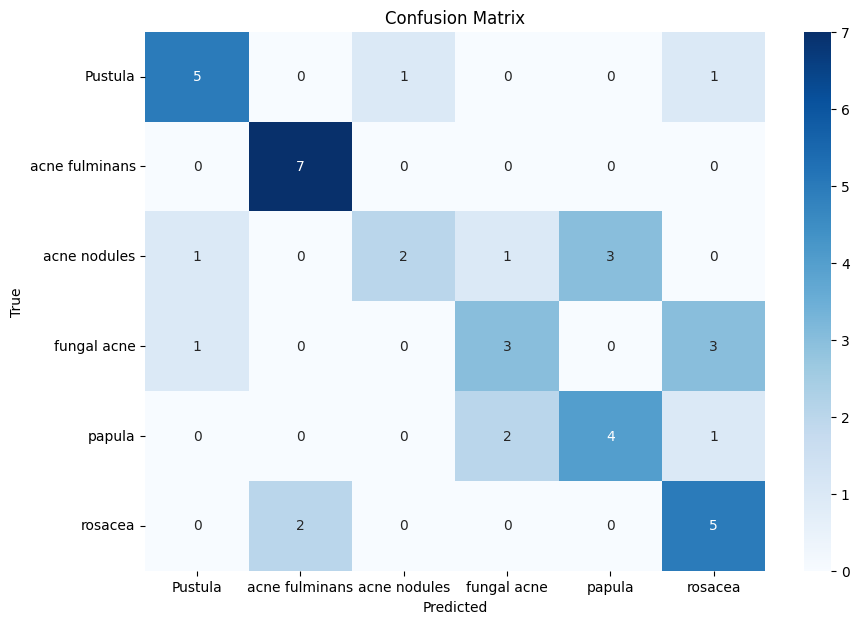

                precision    recall  f1-score   support

       Pustula       0.71      0.71      0.71         7
acne fulminans       0.78      1.00      0.88         7
  acne nodules       0.67      0.29      0.40         7
   fungal acne       0.50      0.43      0.46         7
        papula       0.57      0.57      0.57         7
       rosacea       0.50      0.71      0.59         7

      accuracy                           0.62        42
     macro avg       0.62      0.62      0.60        42
  weighted avg       0.62      0.62      0.60        42



In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Menggunakan 'datagen' yang sama untuk rescaling seperti sebelumnya
test_generator = train_datagen.flow_from_directory(
    test_dir,  # Direktori tempat data uji berada
    target_size=(224, 224),  # Mengubah ukuran gambar menjadi 224x224 piksel
    batch_size=32,  # Ukuran batch saat melakukan prediksi
    class_mode='categorical',  # Mode kelas sebagai kategorikal
    shuffle=False  # Penting untuk menjaga urutan label yang benar dalam confusion matrix
)

# Melakukan prediksi kelas dengan model
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(predictions, axis=1)  # Mendapatkan indeks kelas dengan probabilitas tertinggi

# Mendapatkan label kelas sebenarnya
true_classes = test_generator.classes  # Kelas sebenarnya dari data uji
class_labels = list(test_generator.class_indices.keys())  # Mengambil nama kelas dari generator

# Menghasilkan confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Visualisasi confusion matrix
plt.figure(figsize=(10, 7))  # Menentukan ukuran gambar
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)  # Membuat heatmap confusion matrix
plt.xlabel('Predicted')  # Label sumbu x
plt.ylabel('True')  # Label sumbu y
plt.title('Confusion Matrix')  # Judul gambar
plt.show()  # Menampilkan gambar

# Menghasilkan classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)  # Laporan klasifikasi
print(report)  # Mencetak laporan

In [16]:
from sklearn.metrics import precision_score, recall_score, average_precision_score
import numpy as np

# Simulasi ground truth dan prediksi bounding box (contoh data)
ground_truth_boxes = [
    {'class': 'Pustula', 'bbox': [50, 50, 150, 150]},  # Format: [x_min, y_min, x_max, y_max]
    {'class': 'Papula', 'bbox': [30, 30, 100, 100]},
]

predicted_boxes = [
    {'class': 'Pustula', 'bbox': [55, 55, 145, 145], 'confidence': 0.9},
    {'class': 'Papula', 'bbox': [25, 25, 105, 105], 'confidence': 0.8},
]

iou_threshold = 0.5  # IoU minimal untuk dianggap benar


def calculate_iou(box1, box2):
    """Menghitung Intersection over Union (IoU) antara dua bounding box"""
    x_min1, y_min1, x_max1, y_max1 = box1
    x_min2, y_min2, x_max2, y_max2 = box2

    # Menghitung koordinat area intersection
    inter_x_min = max(x_min1, x_min2)
    inter_y_min = max(y_min1, y_min2)
    inter_x_max = min(x_max1, x_max2)
    inter_y_max = min(y_max1, y_max2)

    # Area intersection
    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)

    # Area setiap bounding box
    box1_area = (x_max1 - x_min1) * (y_max1 - y_min1)
    box2_area = (x_max2 - x_min2) * (y_max2 - y_min2)

    # IoU
    union_area = box1_area + box2_area - inter_area
    iou = inter_area / union_area if union_area > 0 else 0
    return iou


# Evaluasi prediksi
true_positives = 0
false_positives = 0
false_negatives = 0

for gt in ground_truth_boxes:
    matched = False
    for pred in predicted_boxes:
        if gt['class'] == pred['class']:
            iou = calculate_iou(gt['bbox'], pred['bbox'])
            if iou >= iou_threshold:
                true_positives += 1
                matched = True
                break
    if not matched:
        false_negatives += 1

# Prediksi yang tidak cocok dengan ground truth
false_positives = len(predicted_boxes) - true_positives

# Precision, Recall, mAP
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


Precision: 1.00
Recall: 1.00


In [17]:
from keras.preprocessing import image

# Load dan preprocess gambar
img_path = '/content/skin-90/Test/Pustula/p66.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # Mengubah ukuran gambar untuk sesuai dengan input model
img_array = image.img_to_array(img)                     # Mengubah gambar menjadi array
img_array = np.expand_dims(img_array, axis=0)           # Menambahkan dimensi batch
img_array /= 255.0                                      # Menormalisasi array gambar

# Melakukan prediksi gambar
preds = model.predict(img_array)

# Menghitung confidence dan menentukan kelas yang diprediksi
confidence = np.max(preds)
predicted_class = np.argmax(preds)

# Mapping indeks kelas ke label kelas
class_labels = {v: k for k, v in train_generator.class_indices.items()}
predicted_label = class_labels[predicted_class]

# Dictionary yang menyimpan lokasi munculnya jerawat
acne_locations = {
    "Pustula": "dahi, hidung, dagu, pipi",
    "Acne Fulminans": "dahi, hidung, dagu, pipi, rahang",
    "Acne Nodules": "Pipi, dagu, rahang",
    "Fungal Acne": "Dahi dan sisi wajah",
    "Papula": "dahi, hidung, dagu, pipi, rahang",
    "Rosacea": "hidung, pipi, dahi, dagu"
}

def get_rnd_acne_location(acne_type):
    # Mengambil string lokasi berdasarkan jenis jerawat dari dictionary
    locations = acne_locations.get(acne_type, "")

    # Memeriksa apakah string lokasi tidak kosong
    if locations:
        # Memisahkan string lokasi menjadi list
        locations_list = locations.split(", ")

        # lokasi
        location = lc.choice(locations_list)

        return location
    else:
        return "Tipe jerawat tidak ditemukan."

# Menentukan tingkat keparahan berdasarkan confidence
def determine_severity(confidence):
    if confidence < 0.65:
        return "Ringan"
    elif confidence < 0.8:
        return "Sedang"
    else:
        return "Parah"

severity = determine_severity(confidence)
acne_type = predicted_label
print(f"Predicted: {predicted_label}, Tingkat Keparahan: {severity}, Lokasi: {get_rnd_acne_location(acne_type)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted: Pustula, Tingkat Keparahan: Sedang, Lokasi: dagu


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


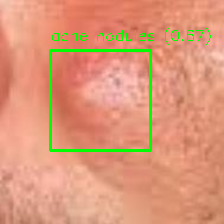

Predicted: acne nodules, Confidence: 0.67, Severity: Sedang


In [18]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from keras.preprocessing import image

# Load dan preprocess gambar
img_path = '/content/skin-90/Test/acne nodules/n71.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # Mengubah ukuran gambar untuk sesuai dengan input model
img_array = image.img_to_array(img)                     # Mengubah gambar menjadi array
img_array = np.expand_dims(img_array, axis=0)           # Menambahkan dimensi batch
img_array /= 255.0                                      # Menormalisasi array gambar

# Melakukan prediksi gambar
preds = model.predict(img_array)

# Menghitung confidence dan menentukan kelas yang diprediksi
confidence = np.max(preds)
predicted_class = np.argmax(preds)

# Mapping indeks kelas ke label kelas
class_labels = {v: k for k, v in train_generator.class_indices.items()}
predicted_label = class_labels[predicted_class]

# Menentukan bounding box secara manual untuk simulasi (x_min, y_min, x_max, y_max)
# Jika model deteksi objek digunakan, bounding box ini akan dihasilkan secara otomatis
bounding_boxes = [
    (50, 50, 150, 150)  # Simulasi bounding box
]

# Membaca ulang gambar asli untuk visualisasi
original_img = cv2.imread(img_path)
original_img = cv2.resize(original_img, (224, 224))  # Resize agar sesuai dengan prediksi

# Menambahkan bounding box pada gambar
for box in bounding_boxes:
    x_min, y_min, x_max, y_max = box
    cv2.rectangle(original_img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Gambar kotak hijau
    cv2.putText(
        original_img,
        f"{predicted_label} ({confidence:.2f})",
        (x_min, y_min - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 255, 0),
        1
    )

# Menampilkan gambar hasil prediksi dengan bounding box
cv2_imshow(original_img)

# Menentukan tingkat keparahan berdasarkan confidence
def determine_severity(confidence):
    if confidence < 0.65:
        return "Ringan"
    elif confidence < 0.8:
        return "Sedang"
    else:
        return "Parah"

severity = determine_severity(confidence)
print(f"Predicted: {predicted_label}, Confidence: {confidence:.2f}, Severity: {severity}")
